# HWAI Project TODO:Code cleanup

Import section

In [1]:
import sys, os, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.applications import MobileNetV2, MobileNet
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn import metrics
import visualkeras, logging,datetime
from tabulate import tabulate


#suppress warnings
tf.get_logger().setLevel(logging.ERROR)

2023-05-28 12:01:36.308565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 12:01:37.546484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGESIZE = 128 #TODO: Check arduino cam size
DATADIR_train = "/home/mattiamorabito/Documents/HwAi-linux/dataset_augmented_simple/train/"
DATADIR_valid = "/home/mattiamorabito/Documents/HwAi-linux/dataset_augmented_simple/valid/"
DATADIR_test  = "/home/mattiamorabito/Documents/HwAi-linux/dataset_augmented_simple/test/"

Check if GPU is mounted

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


2023-05-28 12:01:44.468189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 12:01:44.784639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 12:01:44.784869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loading dataset

In [4]:
from modules import models,utils
reload(models)
reload(utils)
from modules import models,utils

train_ds = tf.keras.utils.image_dataset_from_directory(
                DATADIR_train,seed = 26,
                labels='inferred',
                label_mode='categorical',
                )
val_ds   = tf.keras.utils.image_dataset_from_directory(
                DATADIR_valid,
                seed = 26,
                labels='inferred',
                label_mode='categorical',
                )

class_names = train_ds.class_names
print(class_names)
train_ds = utils.prepare(train_ds, shuffle=True,normalize=True, augment=False, batch_size=32,img_size=(IMAGESIZE,IMAGESIZE))
val_ds   = utils.prepare(val_ds  , shuffle=True,normalize=True, augment=False, batch_size=32,img_size=(IMAGESIZE,IMAGESIZE))


Found 12390 files belonging to 4 classes.
Found 814 files belonging to 4 classes.


2023-05-28 12:01:51.205764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 12:01:51.206012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 12:01:51.206158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

['F_Banana', 'F_Tomato', 'S_Banana', 'S_Tomato']


Plot some images

  0%|          | 0/388 [00:00<?, ?it/s]2023-05-28 12:01:54.229418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12390]
	 [[{{node Placeholder/_0}}]]
2023-05-28 12:01:54.229879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12390]
	 [[{{node Placeholder/_4}}]]
2023-05-28 12:01:58.248339: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. 

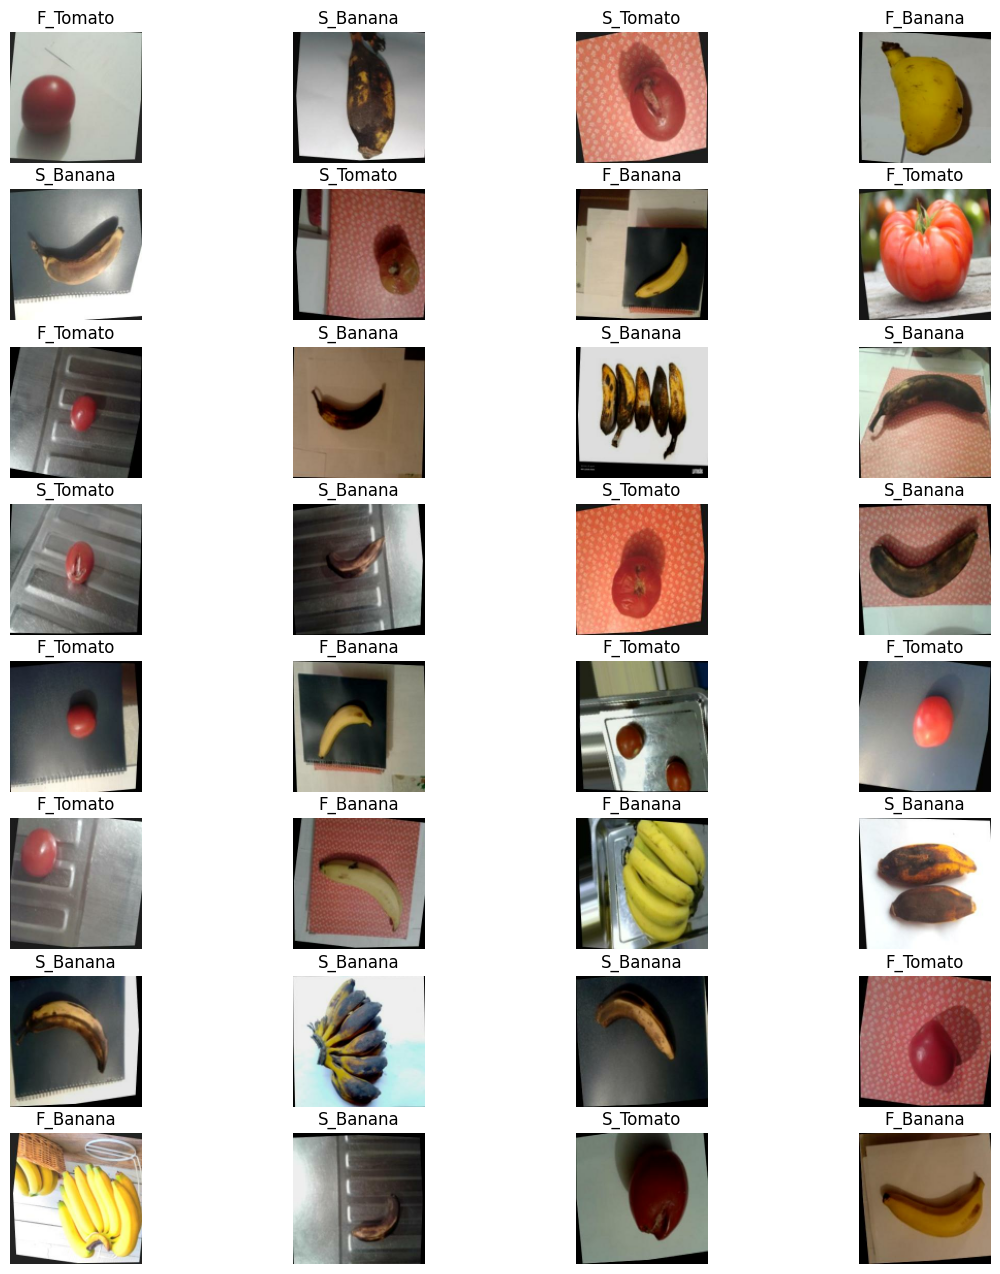

In [5]:
plt.figure(figsize=(14, 16))
for img, label in tqdm(train_ds):
    for i in range(0,32):
        ax = plt.subplot(8, 4, i+1)
        t_img = img[i,:,:,:]
        t_label = label[i,:]
        plt.axis('off')
        #print(t_img)
        plt.title(class_names[np.argmax(t_label)])
        plt.imshow(t_img)    
    break

Model instances and visualization

In [6]:
# import model definitions
from modules import models,utils
reload(models)
reload(utils)
from modules import models,utils

# Istanciate Model    
model = models.JoJoBizzareModelScalable(num_classes=4, input_size=(IMAGESIZE,IMAGESIZE,3), alpha=0.7, beta=5, strides=2, channels=16, gain=2.2)
info,summary = utils.keras_model_memory_usage(model=model,batch_size = 1)
#model.summary()


╒══════╤════════════════════════════════════════╤════════════╤═══════════════════════════╤═════════╤══════════════╤════════════════════╕
│ N#   │ Layer                                  │ Datatype   │   Feature Map Memory (KB) │    MACs │ Parameters   │ Output Shape       │
╞══════╪════════════════════════════════════════╪════════════╪═══════════════════════════╪═════════╪══════════════╪════════════════════╡
│ 1    │ Conv0                                  │ float32    │                   180.224 │ 1216512 │ 308          │ (None, 64, 64, 11) │
├──────┼────────────────────────────────────────┼────────────┼───────────────────────────┼─────────┼──────────────┼────────────────────┤
│ 2    │ CBlock_1_SepConv2D                     │ float32    │                   102.4   │  382976 │ 399          │ (None, 32, 32, 25) │
├──────┼────────────────────────────────────────┼────────────┼───────────────────────────┼─────────┼──────────────┼────────────────────┤
│ 3    │ CBlock_1_BatchNorm              

Model Training (With QAT) [See Ex4 28/04/2023]

In [ ]:
#tflite
import tensorflow_model_optimization as tfmot
reload(utils)
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.00002),
        metrics=['accuracy']
    )

q_aware_model.summary()

Model training (Without QAT)

In [7]:
%load_ext tensorboard

#set checkpoint
checkpoint = ModelCheckpoint('savedmodels/'+str(model.name)+'.h5', save_best_only=True)
log_dir = "logs/fit/" + str(model.name) +"_run_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#train with gpu
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=100,
        batch_size=32,
        callbacks=[
            checkpoint,
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=24, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=8, factor=0.75, min_lr=1e-7),
            tensorboard_callback
            ],
        validation_data=val_ds
    )

Epoch 1/100


2023-05-28 12:02:26.579378: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape injojo_n4_r128x128_a0.7_b5_g2.2_strides2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-28 12:02:32.769851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


387/388 [============================>.] - ETA: 0s - loss: 1.3063 - accuracy: 0.3678

2023-05-28 12:02:42.812268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [814]
	 [[{{node Placeholder/_4}}]]
2023-05-28 12:02:42.812880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [814]
	 [[{{node Placeholder/_4}}]]


388/388 [==============================] - 18s 17ms/step - loss: 1.3063 - accuracy: 0.3683 - val_loss: 1.3903 - val_accuracy: 0.2654 - lr: 5.0000e-05
Epoch 2/100
388/388 [==============================] - 5s 14ms/step - loss: 1.0987 - accuracy: 0.5278 - val_loss: 1.0407 - val_accuracy: 0.5946 - lr: 5.0000e-05
Epoch 3/100
388/388 [==============================] - 6s 14ms/step - loss: 0.9780 - accuracy: 0.6089 - val_loss: 0.8998 - val_accuracy: 0.6720 - lr: 5.0000e-05
Epoch 4/100
388/388 [==============================] - 6s 15ms/step - loss: 0.8863 - accuracy: 0.6554 - val_loss: 0.8033 - val_accuracy: 0.7211 - lr: 5.0000e-05
Epoch 5/100
388/388 [==============================] - 6s 14ms/step - loss: 0.8100 - accuracy: 0.6914 - val_loss: 0.7167 - val_accuracy: 0.7617 - lr: 5.0000e-05
Epoch 6/100
388/388 [==============================] - 6s 14ms/step - loss: 0.7440 - accuracy: 0.7213 - val_loss: 0.6360 - val_accuracy: 0.7973 - lr: 5.0000e-05
Epoch 7/100
388/388 [========================

Pseudo DSE (Expoliring variations of model)

In [ ]:
# Istanciate Model
test_dataset = tf.keras.utils.image_dataset_from_directory(
                              DATADIR_test,
                              labels='inferred',
                              batch_size=20,
                              label_mode='categorical',
                              image_size=(IMAGESIZE, IMAGESIZE))

#extract class names
classes = test_dataset.class_names
#rescale
#test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = utils.prepare(test_dataset, shuffle=True, augment=False, batch_size=32,img_size=IMAGESIZE)



mod = "alphaDSE"  
for alpha in range(4,25,1):
    val = float("{:.1f}".format(alpha*0.1))
    print(val)
    model = models.JoJoBizzareModelScalable(num_classes=8, input_size=IMAGESIZE, alpha=val, beta=4, strides=2, channels=16, gain=2)
    info, summary = utils.keras_model_memory_usage(model=model,batch_size = 1,log = False)
    model_folder = "savedmodels/alphaDSE/"+model.name
    os.makedirs(model_folder)
    checkpoint = ModelCheckpoint(model_folder+'/run.h5', save_best_only=True)
    log_dir = "logs/fit/" + str(model.name) +"_run_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #train with gpu
    with tf.device('/GPU:0'):
        history = model.fit(
            train_ds,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[
                checkpoint,
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=8, factor=0.6, min_lr=1e-6),
                tensorboard_callback
                ],
            validation_data=val_ds
        )
    s = model.evaluate(val_ds)
    info += s
    table = [["Number of parameters","Max Act (KB)","MACs","N layers","Val loss", "Val accuracy"],info]
    with open(model_folder+'/info.txt', 'w') as f:
        f.write(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    with open(model_folder+'/summary.txt', 'w') as f:
        f.write(tabulate(summary, headers='firstrow', tablefmt='fancy_grid'))
    visualkeras.layered_view(model, to_file=model_folder+'/model_img.png',legend=True) # write to disk

    #testing
    model_tmp = tf.keras.models.load_model(model_folder+"/run.h5")
    labels, predictions = utils.predict_from_dataset(test_dataset,model_tmp)
    met = metrics.classification_report(labels, predictions, target_names=classes)
    with open(model_folder+'/classification_report.txt', 'w') as f:
      f.write(met)
    t = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
    s = disp.plot(xticks_rotation='vertical')
    plt.savefig(model_folder+'/confusion_matrix.png',bbox_inches='tight')

Evaluate performance of FLOAT32 Model

In [9]:
print("Evaluate")
reload(utils)
#load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
                              DATADIR_test,
                              labels='inferred',
                              batch_size=20,
                              label_mode='categorical',
                              image_size=(IMAGESIZE, IMAGESIZE))

#extract class names
classes = test_dataset.class_names
#rescale
#test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = utils.prepare(test_dataset, shuffle=True, augment=False, batch_size=32,img_size=(IMAGESIZE,IMAGESIZE))

labels, predictions = utils.predict_from_dataset(test_dataset,model)


Evaluate
Found 564 files belonging to 4 classes.


  0%|          | 0/29 [00:00<?, ?it/s]2023-05-28 12:13:16.697967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [564]
	 [[{{node Placeholder/_4}}]]
2023-05-28 12:13:16.698335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [564]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 29/29 [00:01<00:00, 19.47it/s]


0.9539007092198581 0.9496930106375384 0.9505118218281885
              precision    recall  f1-score   support

    F_Banana       0.98      0.98      0.98       161
    F_Tomato       0.93      0.95      0.94       147
    S_Banana       0.97      0.99      0.98       140
    S_Tomato       0.93      0.88      0.90       116

    accuracy                           0.95       564
   macro avg       0.95      0.95      0.95       564
weighted avg       0.95      0.95      0.95       564



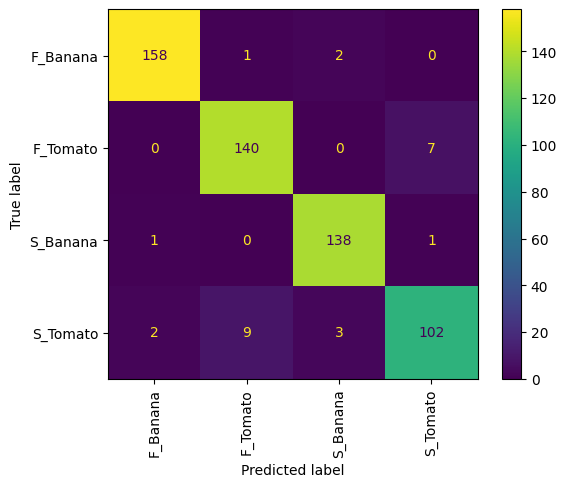

26/26 [==============================] - 0s 6ms/step - loss: 0.1524 - accuracy: 0.9558


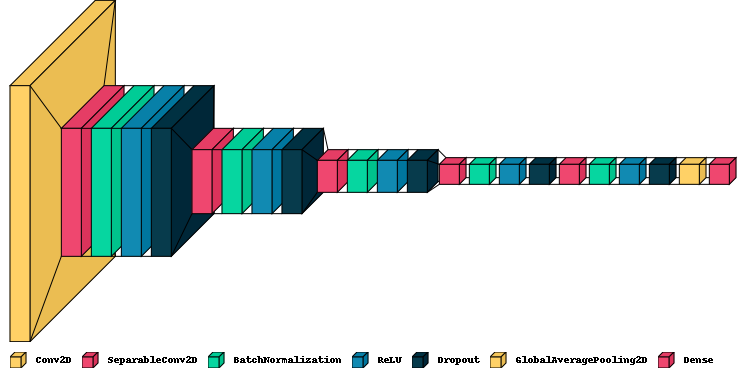

In [10]:
model_folder = "/home/mattiamorabito/Documents/HwAi-linux/savedmodels/"+str(model.name)+"_profiling"
info, summary = utils.keras_model_memory_usage(model=model,batch_size = 1,log = False)
print(metrics.accuracy_score(labels, predictions),
      metrics.balanced_accuracy_score(labels, predictions),
      metrics.f1_score(labels, predictions,average='macro'))

met = metrics.classification_report(labels, predictions, target_names=classes)
print(met)


t = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
s = disp.plot(xticks_rotation='vertical')
plt.savefig(model_folder+'/confusion_matrix.png',bbox_inches='tight')
plt.show()


s = model.evaluate(val_ds)
info += s
table = [["Number of parameters","Max Act (KB)","MACs","N layers","Val loss", "Val accuracy"],info]
with open(model_folder+'/info.txt', 'w') as f:
      f.write(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
with open(model_folder+'/summary.txt', 'w') as f:
      f.write(tabulate(summary, headers='firstrow', tablefmt='fancy_grid'))
with open(model_folder+'/class_report.txt', 'w') as f:
      f.write(met)
visualkeras.layered_view(model, to_file=model_folder+'/model_img.png',legend=True) # write to disk

Save model and convert to TFlite

In [11]:
MODEL_NAME = "/home/mattiamorabito/Documents/HwAi-linux/savedmodels/"+str(model.name)
tf.saved_model.save(model, MODEL_NAME)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NAME)
converter.optimizations = [tf.lite.Optimize.DEFAULT]


def representative_data_gen():
    for input_value, _ in test_dataset.take(20):
        yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
tflite_models_dir = "/home/mattiamorabito/Documents/HwAi-linux/tflite/"

tflite_model_file = pathlib.Path(tflite_models_dir+model.name+'.tflite')
tflite_model_file.write_bytes(tflite_model)

2023-05-28 12:14:16.445578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,32,25]
	 [[{{node inputs}}]]
2023-05-28 12:14:16.459187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,49]
	 [[{{node inputs}}]]
2023-05-28 12:14:16.471716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,8,8,74]
	 [[{{node inputs}}]]
202

58160

Test quantized model

In [13]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
reload(utils)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_ds = tf.keras.utils.image_dataset_from_directory(DATADIR_test,labels='inferred',batch_size=1,label_mode='categorical')
test_ds = utils.prepare(test_ds, shuffle=True, augment=False,normalize=False, batch_size=32,img_size=(IMAGESIZE,IMAGESIZE))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.int8), y))


test_labels, test_imgs = [], []
for img, label in tqdm(test_ds):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = np.argmax(test_labels[item])
  if prediction==label:
    score=score+1
print("| Out of "+str(len(predictions))+" predictions I got " + str(score) + " correct | Accuracy: "+ str(score/len(predictions)*100) + "% |")

Found 564 files belonging to 4 classes.


  0%|          | 0/564 [00:00<?, ?it/s]2023-05-28 12:14:36.248704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [564]
	 [[{{node Placeholder/_4}}]]
2023-05-28 12:14:36.249267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [564]
	 [[{{node Placeholder/_4}}]]
100%|██████████| 564/564 [00:00<00:00, 1089.05it/s]

| Out of 564 predictions I got 142 correct | Accuracy: 25.177304964539005% |


TFLITE.MICRO

In [ ]:
MODEL_TFLITE = "jojo_n8_r72x88_a0.7_b4_g2.2_strides2.tflite"
MODEL_MICRO  = "bestmodel.cpp"

!xxd -i {MODEL_TFLITE} > {MODEL_MICRO}

See model structure and history

Weight distrubution

In [ ]:
all_wi = []
wi = model.weights
for elem in wi:
  var = list(elem.read_value().numpy().flatten())
  all_wi= all_wi +var
s = np.array(all_wi)
sbins = np.linspace(-1,1,256)
plt.hist(s, bins=sbins, facecolor='blue', alpha=0.5)
plt.show()